In [1]:
from collections import defaultdict
from itertools import product
import json
from tqdm.auto import tqdm

import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

In [2]:
c = 1 / np.log(2)

#### Let's do some babysitting of P-scaling-17

In [3]:
with open(f"/om/user/ericjm/results/the-everything-machine/P-scaling-17/1/info.json", 'r') as f:
    info = json.load(f)
len(info['losses'])

200

In [4]:
successes = []
for i in tqdm(range(1, 700)):
    try:
        with open(f"/om/user/ericjm/results/the-everything-machine/P-scaling-17/{i}/config.json", 'r') as f:
            config = json.load(f)
        with open(f"/om/user/ericjm/results/the-everything-machine/P-scaling-17/{i}/info.json", 'r') as f:
            info = json.load(f)
        if len(info['losses']) != 200:
            raise Exception("missing timesteps")
        width, alpha, seed = config['width'], config['alpha'], config['seed']
        successes.append((width, alpha, seed))
    except:
        pass

  0%|          | 0/699 [00:00<?, ?it/s]

In [5]:
widths = [int(w) for w in np.power(2, np.linspace(np.log2(10), np.log2(300), 20))]                                                                  
alphas = [1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8]                                                                                                   
seeds = [0, 1, 2]                                                                                                                                   
configs = list(product(widths, alphas, seeds)) # 480    

# find the indexes of the configs that did not succeed
missing = [i for i, config in enumerate(configs) if config not in successes]
print(",".join([str(i) for i in missing]))


8,73,106,107,122,174,175,177,250,382,412,448


In [6]:
len(missing)

12

## Study Parameter Scaling

In [7]:
alphas = []
for i in tqdm(range(1, 500)):
    try:
        with open(f"/om/user/ericjm/results/the-everything-machine/P-scaling-17/{i}/config.json", 'r') as f:
            config = json.load(f)
            alphas.append(config['alpha'])
    except:
        pass
alphas = sorted(list(set(alphas)))

  0%|          | 0/499 [00:00<?, ?it/s]

In [8]:
alphas

[1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8]

In [9]:
parameter_scaling_losses = defaultdict(list)
parameter_scaling_Ps = defaultdict(list)
parameter_scaling_sacred_ids = defaultdict(list)

for i in tqdm(range(1, 500)):
    try:
        with open(f"/om/user/ericjm/results/the-everything-machine/P-scaling-17/{i}/config.json", 'r') as f:
            config = json.load(f)
        with open(f"/om/user/ericjm/results/the-everything-machine/P-scaling-17/{i}/info.json", 'r') as f:
            info = json.load(f)
        if len(info['losses']) != 200:
            raise Exception("Missing timesteps")
        alpha = config['alpha']
        parameter_scaling_losses[alpha].append(info['losses'][-1])
        parameter_scaling_Ps[alpha].append(info['P'])
        parameter_scaling_sacred_ids[alpha].append(i)
    except Exception as e:
        print(e)

  0%|          | 0/499 [00:00<?, ?it/s]

Missing timesteps
Missing timesteps
Missing timesteps
Missing timesteps
Missing timesteps
Missing timesteps
Missing timesteps
Expecting value: line 1 column 1 (char 0)
Missing timesteps
Missing timesteps
Missing timesteps
Missing timesteps
Missing timesteps
Missing timesteps
Missing timesteps
Missing timesteps
Missing timesteps
Missing timesteps
Missing timesteps
Missing timesteps
Missing timesteps
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Missing timesteps
Missing timesteps
Missing timesteps
Missing timesteps
Missing timesteps
Missing timesteps
Missing timesteps
Missing timesteps
Missing timesteps
Missing timesteps
Expecting value: line 1 column 1 (char 0)
Missing timesteps
Missing timesteps
Missing timesteps
Missing timesteps
Missing timesteps
Missing timesteps
Missing timesteps
Missing timesteps
Missing timesteps
Missing timesteps
Missing timesteps
Missing timesteps
Missing timesteps
Missing timestep

In [10]:
for alpha in alphas:
    parameter_scaling_Ps[alpha], parameter_scaling_losses[alpha], parameter_scaling_sacred_ids[alpha] = zip(*sorted(list(zip(parameter_scaling_Ps[alpha], parameter_scaling_losses[alpha], parameter_scaling_sacred_ids[alpha])), key=lambda x: x[0]))

/tmp/ipykernel_37364/3293609377.py:20: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label="Task Zipf exponent: $\\alpha+1$", ticks=alphas)


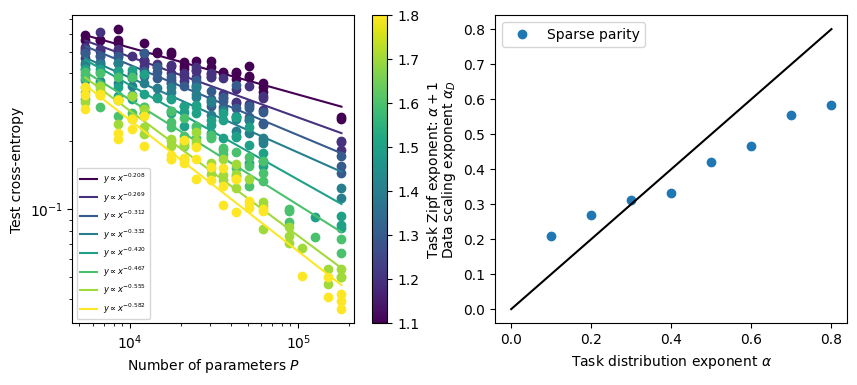

In [31]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
colors = plt.cm.viridis(np.linspace(0, 1, len(alphas)))

slopes = {}
for alpha in alphas:
    plt.plot(parameter_scaling_Ps[alpha], parameter_scaling_losses[alpha], 'o', color=colors[alphas.index(alpha)])

    xs = parameter_scaling_Ps[alpha]
    ys = parameter_scaling_losses[alpha]
    i0, i1 = 0, len(xs)
    reg = LinearRegression().fit(np.log(xs[i0:i1]).reshape(-1, 1), np.log(ys[i0:i1]))
    reg_ys = np.exp(reg.intercept_) * np.power(xs, reg.coef_[0])
    plt.plot(xs[i0:i1], reg_ys[i0:i1], color=colors[alphas.index(alpha)], label=f"$y\propto x^{{{reg.coef_[0]:.3f}}}$")
    slopes[alpha] = reg.coef_[0]
# add a colorbar for the alphas
sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=plt.Normalize(vmin=min(alphas), vmax=max(alphas)))
sm._A = []
plt.colorbar(sm, label="Task Zipf exponent: $\\alpha+1$", ticks=alphas)
# set colorbar tick labels to be the alphas - 1
# plt.clim(min(alphas), max(alphas))
plt.xscale('log')
plt.xlabel("Number of parameters $P$")
plt.yscale('log')
plt.ylabel('Test cross-entropy')
plt.legend(prop={'size': 6})


plt.subplot(1, 2, 2)
alphas_arr = np.array(alphas)
plt.plot(alphas_arr-1, [abs(slopes[alpha]) for alpha in alphas], 'o', label='Sparse parity')
xs_alphas = np.linspace(0, 0.8, 1000)
plt.plot(xs_alphas, xs_alphas, color='black')
plt.xlabel(r"Task distribution exponent $\alpha$")
plt.ylabel(r"Data scaling exponent $\alpha_D$")
plt.legend()

# plt.suptitle("Scaling of loss w.r.t. training data D")
# plt.tight_layout(pad=1.0)
# plt.savefig('../figures/sparse-parity-data-scaling-dependence.png', dpi=300)

# colors = plt.cm.viridis(np.linspace(0, 1, len(alphas)))
# for alpha in alphas:
#     plt.plot(parameter_scaling_Ps[alpha], parameter_scaling_losses[alpha], 'o', color=colors[alphas.index(alpha)], label=f"$\\alpha={alpha}$")

# plt.xscale('log')
# plt.yscale('log')

/tmp/ipykernel_37364/2602023341.py:62: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label="Task Zipf exponent: $\\alpha+1$", ticks=alphas)


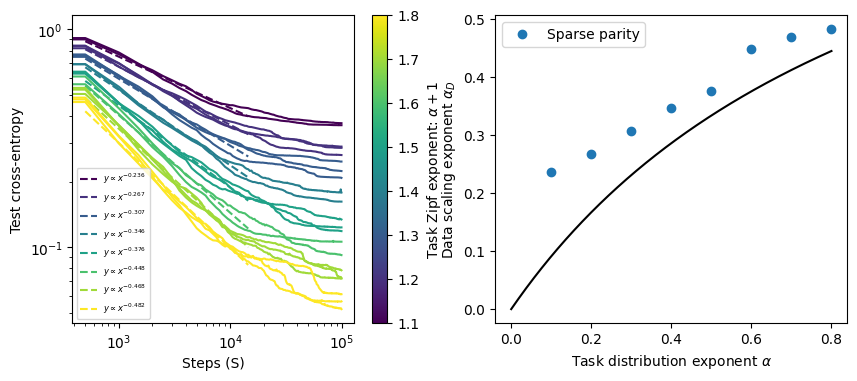

In [37]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)

colors = plt.cm.viridis(np.linspace(0, 1, len(alphas)))
slopes = {}
for alpha in alphas:

    steps_data = []
    losses_data = []

    exp_id = parameter_scaling_sacred_ids[alpha][-1]
    with open(f"/om/user/ericjm/results/the-everything-machine/P-scaling-17/{exp_id}/info.json", 'r') as f:
        info = json.load(f)
    with open(f"/om/user/ericjm/results/the-everything-machine/P-scaling-17/{exp_id}/config.json", 'r') as f:
        config = json.load(f)
    if config['width'] == 300:
        steps = info['log_steps']
        losses = np.array(info['losses']) * c
        plt.plot(steps, losses, color=colors[alphas.index(alpha)])
        i0, i1 = steps.index(500), steps.index(15000)
        steps_data.extend(steps[i0:i1])
        losses_data.extend(losses[i0:i1])


    exp_id = parameter_scaling_sacred_ids[alpha][-2]
    with open(f"/om/user/ericjm/results/the-everything-machine/P-scaling-17/{exp_id}/info.json", 'r') as f:
        info = json.load(f)
    with open(f"/om/user/ericjm/results/the-everything-machine/P-scaling-17/{exp_id}/config.json", 'r') as f:
        config = json.load(f)
    if config['width'] == 300:
        steps = info['log_steps']
        losses = np.array(info['losses']) * c
        plt.plot(steps, losses, color=colors[alphas.index(alpha)])
        i0, i1 = steps.index(500), steps.index(15000)
        steps_data.extend(steps[i0:i1])
        losses_data.extend(losses[i0:i1])

    exp_id = parameter_scaling_sacred_ids[alpha][-3]
    with open(f"/om/user/ericjm/results/the-everything-machine/P-scaling-17/{exp_id}/info.json", 'r') as f:
        info = json.load(f)
    with open(f"/om/user/ericjm/results/the-everything-machine/P-scaling-17/{exp_id}/config.json", 'r') as f:
        config = json.load(f)
    if config['width'] == 300:
        steps = info['log_steps']
        losses = np.array(info['losses']) * c
        plt.plot(steps, losses, color=colors[alphas.index(alpha)])
        i0, i1 = steps.index(500), steps.index(15000)
        steps_data.extend(steps[i0:i1])
        losses_data.extend(losses[i0:i1])

    xs = steps_data
    ys = losses_data
    reg = LinearRegression().fit(np.log(xs).reshape(-1, 1), np.log(ys))
    xs = np.linspace(min(xs), max(xs), 1000)
    reg_ys = np.exp(reg.intercept_) * np.power(xs, reg.coef_[0])
    plt.plot(xs, reg_ys, color=colors[alphas.index(alpha)], label=f"$y\propto x^{{{reg.coef_[0]:.3f}}}$", linestyle='--')
    slopes[alpha] = reg.coef_[0]
# add a colorbar for the alphas
sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=plt.Normalize(vmin=min(alphas), vmax=max(alphas)))
sm._A = []
plt.colorbar(sm, label="Task Zipf exponent: $\\alpha+1$", ticks=alphas)
# set colorbar tick labels to be the alphas - 1
# plt.clim(min(alphas), max(alphas))
plt.xscale('log')
plt.xlabel("Steps (S)")
plt.yscale('log')
plt.ylabel('Test cross-entropy')
plt.legend(prop={'size': 6})


plt.subplot(1, 2, 2)
alphas_arr = np.array(alphas)
plt.plot(alphas_arr-1, [abs(slopes[alpha]) for alpha in alphas], 'o', label='Sparse parity')
xs_alphas = np.linspace(0, 0.8, 1000)
plt.plot(xs_alphas, xs_alphas / (1 + xs_alphas), color='black')
plt.xlabel(r"Task distribution exponent $\alpha$")
plt.ylabel(r"Data scaling exponent $\alpha_D$")
plt.legend()

# plt.suptitle("Scaling of loss w.r.t. training data D")
# plt.tight_layout(pad=1.0)
# plt.savefig('../figures/sparse-parity-data-scaling-dependence.png', dpi=300)

# colors = plt.cm.viridis(np.linspace(0, 1, len(alphas)))
# for alpha in alphas:
#     plt.plot(parameter_scaling_Ps[alpha], parameter_scaling_losses[alpha], 'o', color=colors[alphas.index(alpha)], label=f"$\\alpha={alpha}$")

# plt.xscale('log')
# plt.yscale('log')

# Combined plot for appendix (load up data from scratch too)

In [3]:
# load up parameter scaling data

alphas_P = []
for i in tqdm(range(1, 600)):
    try:
        with open(f"/om/user/ericjm/results/the-everything-machine/P-scaling-17/{i}/config.json", 'r') as f:
            config = json.load(f)
            alphas_P.append(config['alpha'])
    except:
        pass
alphas_P = sorted(list(set(alphas_P)))

parameter_scaling_losses = defaultdict(list)
parameter_scaling_Ps = defaultdict(list)
parameter_scaling_sacred_ids = defaultdict(list)

for i in tqdm(range(1, 500)):
    try:
        with open(f"/om/user/ericjm/results/the-everything-machine/P-scaling-17/{i}/config.json", 'r') as f:
            config = json.load(f)
        with open(f"/om/user/ericjm/results/the-everything-machine/P-scaling-17/{i}/info.json", 'r') as f:
            info = json.load(f)
        if len(info['losses']) != 200:
            raise Exception("Missing timesteps")
        alpha = config['alpha']
        parameter_scaling_losses[alpha].append(info['losses'][-1]*c)
        parameter_scaling_Ps[alpha].append(info['P'])
        parameter_scaling_sacred_ids[alpha].append(i)
    except Exception as e:
        pass

for alpha in alphas_P:
    parameter_scaling_Ps[alpha], parameter_scaling_losses[alpha], parameter_scaling_sacred_ids[alpha] = zip(*sorted(list(zip(parameter_scaling_Ps[alpha], parameter_scaling_losses[alpha], parameter_scaling_sacred_ids[alpha])), key=lambda x: x[0]))

  0%|          | 0/599 [00:00<?, ?it/s]

  0%|          | 0/499 [00:00<?, ?it/s]

In [4]:
alphas_D = []
for i in tqdm(range(1, 400)):
    try:
        with open(f"/om/user/ericjm/results/the-everything-machine/D-scaling-9/{i}/config.json", 'r') as f:
            config = json.load(f)
            alphas_D.append(config['alpha'])
    except:
        pass
alphas_D = sorted(list(set(alphas_D)))

data_scaling_losses = defaultdict(list)
data_scaling_Ds = defaultdict(list)

for i in tqdm(range(1, 400)):
    try:
        with open(f"/om/user/ericjm/results/the-everything-machine/D-scaling-9/{i}/config.json", 'r') as f:
            config = json.load(f)
        with open(f"/om/user/ericjm/results/the-everything-machine/D-scaling-9/{i}/info.json", 'r') as f:
            info = json.load(f)
        # print(len(info['losses']))
        # break
        if len(info['losses']) != 200:
            raise Exception("Missing timesteps")
        alpha = config['alpha']
        data_scaling_losses[alpha].append(min(info['losses'])*c)
        data_scaling_Ds[alpha].append(info['D'])
    except Exception as e:
        pass

for alpha in alphas_D:
    data_scaling_Ds[alpha], data_scaling_losses[alpha] = zip(*sorted(list(zip(data_scaling_Ds[alpha], data_scaling_losses[alpha])), key=lambda x: x[0]))


  0%|          | 0/399 [00:00<?, ?it/s]

  0%|          | 0/399 [00:00<?, ?it/s]

/tmp/ipykernel_44505/3663995785.py:21: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm, ticks=alphas_P)
/tmp/ipykernel_44505/3663995785.py:114: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm, ticks=alphas_P)
/tmp/ipykernel_44505/3663995785.py:165: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space fr

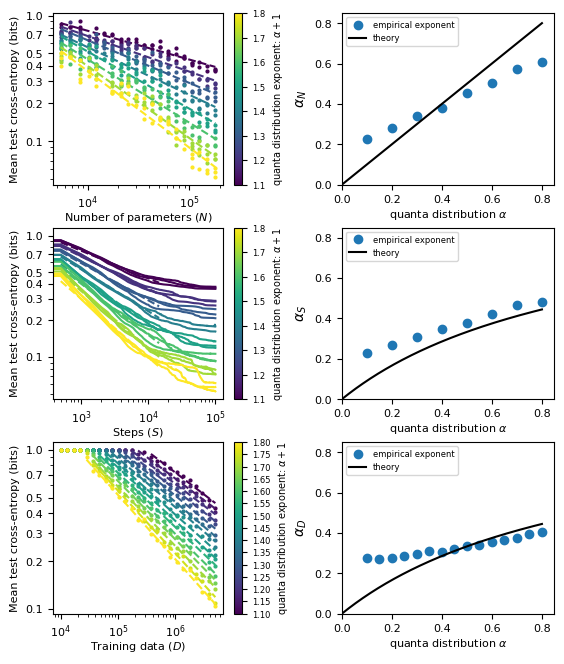

In [5]:
plt.figure(figsize=(5.5, 6.5))


plt.subplot(3, 2, 1)
colors = plt.cm.viridis(np.linspace(0, 1, len(alphas_P)))

slopes = {}
for alpha in alphas_P:
    plt.plot(parameter_scaling_Ps[alpha], parameter_scaling_losses[alpha], 'o', color=colors[alphas_P.index(alpha)], markersize=2)

    xs = parameter_scaling_Ps[alpha]
    ys = parameter_scaling_losses[alpha]
    i0, i1 = 0, len(xs)
    reg = LinearRegression().fit(np.log(xs[i0:i1]).reshape(-1, 1), np.log(ys[i0:i1]))
    reg_ys = np.exp(reg.intercept_) * np.power(xs, reg.coef_[0])
    plt.plot(xs[i0:i1], reg_ys[i0:i1], color=colors[alphas_P.index(alpha)], label=f"$y\propto x^{{{reg.coef_[0]:.3f}}}$", linestyle='--')
    slopes[alpha] = reg.coef_[0]
# add a colorbar for the alphas
sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=plt.Normalize(vmin=min(alphas_P), vmax=max(alphas_P)))
sm._A = []
cbar = plt.colorbar(sm, ticks=alphas_P)
cbar.ax.set_ylabel(r"quanta distribution exponent: $\alpha + 1$", fontsize=7)
cbar.ax.tick_params(labelsize=6)
# set colorbar tick labels to be the alphas - 1
# plt.clim(min(alphas), max(alphas))
plt.xscale('log')
plt.xlabel("Number of parameters ($N$)", fontsize=8, labelpad=0)
plt.yscale('log')
plt.ylabel('Mean test cross-entropy (bits)', fontsize=8)
plt.xticks(fontsize=8)
yticks = [0.1, 0.2, 0.3, 0.4, 0.5, 0.7, 1.0]
plt.yticks(yticks, [f"{ytick:.1f}" for ytick in yticks], fontsize=8)


# plt.legend(prop={'size': 6})


plt.subplot(3, 2, 2)
alphas_arr = np.array(alphas_P)
plt.plot(alphas_arr-1, [abs(slopes[alpha]) for alpha in alphas_P], 'o', label='empirical exponent')
xs_alphas = np.linspace(0, 0.8, 1000)
plt.plot(xs_alphas, xs_alphas, color='black', label='theory')
plt.xlabel(r"quanta distribution $\alpha$", fontsize=8, labelpad=2)
plt.ylabel(r"$\alpha_N$", fontsize=10)
plt.xlim(0, 0.85)
plt.ylim(0, 0.85)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.legend(prop={'size': 6}, loc='upper left')





plt.subplot(3, 2, 3)

colors = plt.cm.viridis(np.linspace(0, 1, len(alphas_P)))
slopes = {}
for alpha in alphas_P:

    steps_data = []
    losses_data = []

    exp_id = parameter_scaling_sacred_ids[alpha][-1]
    with open(f"/om/user/ericjm/results/the-everything-machine/P-scaling-17/{exp_id}/info.json", 'r') as f:
        info = json.load(f)
    with open(f"/om/user/ericjm/results/the-everything-machine/P-scaling-17/{exp_id}/config.json", 'r') as f:
        config = json.load(f)
    if config['width'] == 300:
        steps = info['log_steps']
        losses = np.array(info['losses']) * c
        plt.plot(steps, losses, color=colors[alphas_P.index(alpha)])
        i0, i1 = steps.index(500), steps.index(15000)
        steps_data.extend(steps[i0:i1])
        losses_data.extend(losses[i0:i1])


    exp_id = parameter_scaling_sacred_ids[alpha][-2]
    with open(f"/om/user/ericjm/results/the-everything-machine/P-scaling-17/{exp_id}/info.json", 'r') as f:
        info = json.load(f)
    with open(f"/om/user/ericjm/results/the-everything-machine/P-scaling-17/{exp_id}/config.json", 'r') as f:
        config = json.load(f)
    if config['width'] == 300:
        steps = info['log_steps']
        losses = np.array(info['losses']) * c
        plt.plot(steps, losses, color=colors[alphas_P.index(alpha)])
        i0, i1 = steps.index(500), steps.index(15000)
        steps_data.extend(steps[i0:i1])
        losses_data.extend(losses[i0:i1])

    exp_id = parameter_scaling_sacred_ids[alpha][-3]
    with open(f"/om/user/ericjm/results/the-everything-machine/P-scaling-17/{exp_id}/info.json", 'r') as f:
        info = json.load(f)
    with open(f"/om/user/ericjm/results/the-everything-machine/P-scaling-17/{exp_id}/config.json", 'r') as f:
        config = json.load(f)
    if config['width'] == 300:
        steps = info['log_steps']
        losses = np.array(info['losses']) * c
        plt.plot(steps, losses, color=colors[alphas_P.index(alpha)])
        i0, i1 = steps.index(500), steps.index(15000)
        steps_data.extend(steps[i0:i1])
        losses_data.extend(losses[i0:i1])

    xs = steps_data
    ys = losses_data
    reg = LinearRegression().fit(np.log(xs).reshape(-1, 1), np.log(ys))
    xs = np.linspace(min(xs), max(xs), 1000)
    reg_ys = np.exp(reg.intercept_) * np.power(xs, reg.coef_[0])
    plt.plot(xs, reg_ys, color=colors[alphas_P.index(alpha)], label=f"$y\propto x^{{{reg.coef_[0]:.3f}}}$", linestyle='--')
    slopes[alpha] = reg.coef_[0]
# add a colorbar for the alphas
sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=plt.Normalize(vmin=min(alphas_P), vmax=max(alphas_P)))
sm._A = []
cbar = plt.colorbar(sm, ticks=alphas_P)
cbar.ax.set_ylabel(r"quanta distribution exponent: $\alpha + 1$", fontsize=7)
cbar.ax.tick_params(labelsize=6)
# set colorbar tick labels to be the alphas - 1
# plt.clim(min(alphas), max(alphas))
plt.xscale('log')
plt.xlabel("Steps ($S$)", fontsize=8, labelpad=0)
plt.yscale('log')
plt.ylabel('Mean test cross-entropy (bits)', fontsize=8)
plt.xticks(fontsize=8)
yticks = [0.1, 0.2, 0.3, 0.4, 0.5, 0.7, 1.0]
plt.yticks(yticks, [f"{ytick:.1f}" for ytick in yticks], fontsize=8)
# plt.legend(prop={'size': 6})


plt.subplot(3, 2, 4)
alphas_arr = np.array(alphas_P)
plt.plot(alphas_arr-1, [abs(slopes[alpha]) for alpha in alphas_P], 'o', label='empirical exponent')
xs_alphas = np.linspace(0, 0.8, 1000)
plt.plot(xs_alphas, xs_alphas / (1 + xs_alphas), color='black', label='theory')
plt.xlabel(r"quanta distribution $\alpha$", fontsize=8, labelpad=2)
plt.ylabel(r"$\alpha_S$", fontsize=10)
plt.xlim(0, 0.85)
plt.ylim(0, 0.85)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.legend(prop={'size': 6}, loc='upper left')





plt.subplot(3, 2, 5)

iis = {alpha: ((np.array(data_scaling_losses[alpha]) < 0.95).nonzero()[0].min(), 25) for alpha in alphas_D}

colors = plt.cm.viridis(np.linspace(0, 1, len(alphas_D)))
slopes = {}
for alpha in alphas_D:
    plt.plot(data_scaling_Ds[alpha], data_scaling_losses[alpha], 'o', color=colors[alphas_D.index(alpha)], markersize=2)

    xs = data_scaling_Ds[alpha]
    ys = data_scaling_losses[alpha]
    i0, i1 = iis[alpha]
    reg = LinearRegression().fit(np.log(xs[i0:i1]).reshape(-1, 1), np.log(ys[i0:i1]))
    reg_ys = np.exp(reg.intercept_) * np.power(xs, reg.coef_[0])
    plt.plot(xs[i0:i1], reg_ys[i0:i1], color=colors[alphas_D.index(alpha)], label=f"$y\propto x^{{{reg.coef_[0]:.3f}}}$", linestyle='--')
    slopes[alpha] = reg.coef_[0]
# add a colorbar for the alphas
sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=plt.Normalize(vmin=min(alphas_D), vmax=max(alphas_D)))
sm._A = []
cbar = plt.colorbar(sm, ticks=alphas_D)
cbar.ax.set_ylabel(r"quanta distribution exponent: $\alpha + 1$", fontsize=7)
cbar.ax.tick_params(labelsize=6)
# set colorbar tick labels to be the alphas - 1
# plt.clim(min(alphas), max(alphas))
plt.xscale('log')
plt.xlabel("Training data ($D$)", fontsize=8, labelpad=0)
plt.yscale('log')
plt.ylabel('Mean test cross-entropy (bits)', fontsize=8)
plt.xticks(fontsize=8)
yticks = [0.1, 0.2, 0.3, 0.4, 0.5, 0.7, 1.0]
plt.yticks(yticks, [f"{ytick:.1f}" for ytick in yticks], fontsize=8)
# plt.legend(prop={'size': 6})


plt.subplot(3, 2, 6)
alphas_arr = np.array(alphas_D)
plt.plot(alphas_arr-1, [abs(slopes[alpha]) for alpha in alphas_D], 'o', label='empirical exponent')
xs_alphas = np.linspace(0, 0.8, 1000)
plt.plot(xs_alphas, xs_alphas / (xs_alphas + 1), color='black', label='theory')
plt.xlabel(r"quanta distribution $\alpha$", fontsize=8, labelpad=2)
plt.ylabel(r"$\alpha_D$", fontsize=10)
plt.legend(prop={'size': 6}, loc='upper left')
plt.xlim(0, 0.85)
plt.ylim(0, 0.85)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)

# plt.suptitle("REMINDER: RECREATE WHEN ALL RUNS ARE DONE", fontsize=8)
plt.tight_layout(pad=0.2)
# reduce vertical space between rows
plt.subplots_adjust(hspace=0.25)
plt.savefig('../figures/sparse-parity-all-scaling-varying-alpha.pdf')


# First figure showing scaling alpha vs quanta alpha for N and S for multitask task sparse parity and for Pythia

In [13]:
# load up parameter scaling data

alphas_P = []
for i in tqdm(range(1, 500)):
    try:
        with open(f"/om/user/ericjm/results/the-everything-machine/P-scaling-17/{i}/config.json", 'r') as f:
            config = json.load(f)
            alphas_P.append(config['alpha'])
    except:
        pass
alphas_P = sorted(list(set(alphas_P)))

parameter_scaling_losses = defaultdict(list)
parameter_scaling_Ps = defaultdict(list)
parameter_scaling_sacred_ids = defaultdict(list)

for i in tqdm(range(1, 500)):
    try:
        with open(f"/om/user/ericjm/results/the-everything-machine/P-scaling-17/{i}/config.json", 'r') as f:
            config = json.load(f)
        with open(f"/om/user/ericjm/results/the-everything-machine/P-scaling-17/{i}/info.json", 'r') as f:
            info = json.load(f)
        if len(info['losses']) != 200:
            raise Exception("Missing timesteps")
        alpha = config['alpha']
        parameter_scaling_losses[alpha].append(info['losses'][-1]*c)
        parameter_scaling_Ps[alpha].append(info['P'])
        parameter_scaling_sacred_ids[alpha].append(i)
    except Exception as e:
        pass

for alpha in alphas_P:
    parameter_scaling_Ps[alpha], parameter_scaling_losses[alpha], parameter_scaling_sacred_ids[alpha] = zip(*sorted(list(zip(parameter_scaling_Ps[alpha], parameter_scaling_losses[alpha], parameter_scaling_sacred_ids[alpha])), key=lambda x: x[0]))

  0%|          | 0/499 [00:00<?, ?it/s]

  0%|          | 0/499 [00:00<?, ?it/s]

In [14]:
curves = np.load("/om/user/ericjm/results/the-everything-machine/pythia-2/pythia-2.npy")
curves = curves[:10000000, :]
timeseries19m = np.load("/om/user/ericjm/results/phase-changes/pythia-3/pythia-19m.npy")
timeseries125m = np.load("/om/user/ericjm/results/phase-changes/pythia-2/pythia-125m.npy")
timeseries350m = np.load("/om/user/ericjm/results/phase-changes/pythia-4/pythia-350m.npy")
timeseries800m = np.load("/om/user/ericjm/results/phase-changes/pythia-5/pythia-800m.npy")
timeseries1_3b = np.load("/om/user/ericjm/results/phase-changes/pythia-6/pythia-1.3b.npy")
# convert from nats to bits
curves = curves / np.log(2)
timeseries19m = timeseries19m / np.log(2)
timeseries125m = timeseries125m / np.log(2)
timeseries350m = timeseries350m / np.log(2)
timeseries800m = timeseries800m / np.log(2)
timeseries1_3b = timeseries1_3b / np.log(2)

In [16]:
timeseries19m_mean = np.mean(timeseries19m, axis=0)
timeseries125m_mean = np.mean(timeseries125m, axis=0)
timeseries350m_mean = np.mean(timeseries350m, axis=0)
timeseries800m_mean = np.mean(timeseries800m, axis=0)
timeseries1_3b_mean = np.mean(timeseries1_3b, axis=0)

In [40]:
model_names = [
    "pythia-19m",
    "pythia-125m",
    "pythia-350m",
    "pythia-800m",
    "pythia-1.3b",
    "pythia-2.7b",
    "pythia-6.7b",
    "pythia-13b"
]

In [41]:
steps = list(range(1000, 144000, 1000))

model_data = {
    "pythia-125m": timeseries125m_mean,
    "pythia-350m": timeseries350m_mean,
    "pythia-800m": timeseries800m_mean,
    "pythia-1.3b": timeseries1_3b_mean
}

slopes = {}

for model_name, data in model_data.items():
    X = np.log(steps[10:100]).reshape(-1, 1)
    y = np.log(data[10:100])
    reg = LinearRegression().fit(X, y)
    slopes[model_name] = reg.coef_[0]

print(slopes)

{'pythia-125m': -0.03682149530920027, 'pythia-350m': -0.05155375630457887, 'pythia-800m': -0.04888900572715795, 'pythia-1.3b': -0.06044252537702591}


In [42]:
size_names = {
    'pythia-19m': '19m',
    'pythia-125m': '85m',
    'pythia-350m': '300m',
    'pythia-800m': '800m',
    'pythia-1.3b': '1.2b',
    'pythia-2.7b': '2.5b',
    'pythia-6.7b': '6.4b'
}

In [43]:
slopes_N = {}
for alpha in alphas_P:
    xs = parameter_scaling_Ps[alpha]
    ys = parameter_scaling_losses[alpha]
    i0, i1 = 0, len(xs)
    reg = LinearRegression().fit(np.log(xs[i0:i1]).reshape(-1, 1), np.log(ys[i0:i1]))
    reg_ys = np.exp(reg.intercept_) * np.power(xs, reg.coef_[0])
    slopes_N[alpha] = reg.coef_[0]

slopes_N = [abs(slopes_N[alpha]) for alpha in alphas_P]

In [44]:
slopes_S = {}
for alpha in alphas_P:

    steps_data = []
    losses_data = []

    exp_id = parameter_scaling_sacred_ids[alpha][-1]
    with open(f"/om/user/ericjm/results/the-everything-machine/P-scaling-17/{exp_id}/info.json", 'r') as f:
        info = json.load(f)
    with open(f"/om/user/ericjm/results/the-everything-machine/P-scaling-17/{exp_id}/config.json", 'r') as f:
        config = json.load(f)
    if config['width'] == 300:
        steps = info['log_steps']
        losses = np.array(info['losses']) * c
        i0, i1 = steps.index(500), steps.index(15000)
        steps_data.extend(steps[i0:i1])
        losses_data.extend(losses[i0:i1])


    exp_id = parameter_scaling_sacred_ids[alpha][-2]
    with open(f"/om/user/ericjm/results/the-everything-machine/P-scaling-17/{exp_id}/info.json", 'r') as f:
        info = json.load(f)
    with open(f"/om/user/ericjm/results/the-everything-machine/P-scaling-17/{exp_id}/config.json", 'r') as f:
        config = json.load(f)
    if config['width'] == 300:
        steps = info['log_steps']
        losses = np.array(info['losses']) * c
        i0, i1 = steps.index(500), steps.index(15000)
        steps_data.extend(steps[i0:i1])
        losses_data.extend(losses[i0:i1])

    exp_id = parameter_scaling_sacred_ids[alpha][-3]
    with open(f"/om/user/ericjm/results/the-everything-machine/P-scaling-17/{exp_id}/info.json", 'r') as f:
        info = json.load(f)
    with open(f"/om/user/ericjm/results/the-everything-machine/P-scaling-17/{exp_id}/config.json", 'r') as f:
        config = json.load(f)
    if config['width'] == 300:
        steps = info['log_steps']
        losses = np.array(info['losses']) * c
        i0, i1 = steps.index(500), steps.index(15000)
        steps_data.extend(steps[i0:i1])
        losses_data.extend(losses[i0:i1])

    xs = steps_data
    ys = losses_data
    reg = LinearRegression().fit(np.log(xs).reshape(-1, 1), np.log(ys))
    xs = np.linspace(min(xs), max(xs), 1000)
    reg_ys = np.exp(reg.intercept_) * np.power(xs, reg.coef_[0])
    slopes_S[alpha] = reg.coef_[0]

slopes_S = [abs(slopes_S[alpha]) for alpha in alphas_P]

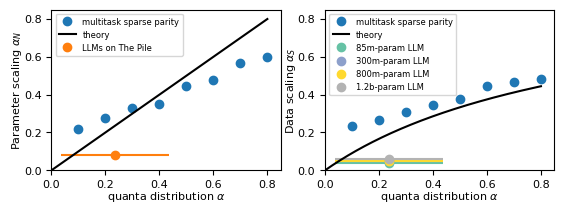

In [50]:
plt.figure(figsize=(5.5, 2))

plt.subplot(1, 2, 1)
alphas_arr = np.array(alphas_P)
plt.plot(alphas_arr - 1, slopes_N, 'o', color='C0', label='multitask sparse parity')

pythia_alpha = 0.237
pythia_uncertainty = 0.2
pythia_slope = 0.083
plt.errorbar([pythia_alpha], [pythia_slope], xerr=pythia_uncertainty, fmt='o', color='C1', label='LLMs on The Pile')

xs = np.linspace(0, 0.8, 1000)
plt.plot(xs, xs, color='black', label='theory')

plt.xlim(0, 0.85)
plt.ylim(0, 0.85)
plt.xticks([0, 0.2, 0.4, 0.6, 0.8], fontsize=8)
plt.yticks([0, 0.2, 0.4, 0.6, 0.8], fontsize=8)
plt.xlabel(r"quanta distribution $\alpha$", fontsize=8, labelpad=0)
plt.ylabel(r"Parameter scaling $\alpha_N$", fontsize=8, labelpad=0)
plt.legend(prop={'size': 6}, loc='upper left')



plt.subplot(1, 2, 2)
alphas_arr = np.array(alphas_P)
plt.plot(alphas_arr - 1, slopes_S, 'o', color='C0', label='multitask sparse parity')

pythia_alpha = 0.237
pythia_uncertainty = 0.2
colors = plt.cm.Set2(np.linspace(0, 1, len(slopes)))
for i, (model_name, slope) in enumerate(slopes.items()):
    plt.errorbar([pythia_alpha], [abs(slope)], xerr=pythia_uncertainty, fmt='o', color=colors[i], label=f'{size_names[model_name]}-param LLM')

xs = np.linspace(0, 0.8, 1000)
plt.plot(xs, xs / (1 + xs), color='black', label='theory')

plt.xlim(0, 0.85)
plt.ylim(0, 0.85)
plt.xticks([0, 0.2, 0.4, 0.6, 0.8], fontsize=8)
plt.yticks([0, 0.2, 0.4, 0.6, 0.8], fontsize=8)
plt.xlabel(r"quanta distribution $\alpha$", fontsize=8, labelpad=0)
plt.ylabel(r"Data scaling $\alpha_S$", fontsize=8, labelpad=0)
plt.legend(prop={'size': 6}, loc='upper left')

plt.tight_layout(pad=0.2)
plt.savefig('../figures/summary-power-law-vs-scaling-exponents.pdf')


Text(0.5, 1.0, 'Mean loss dynamics')

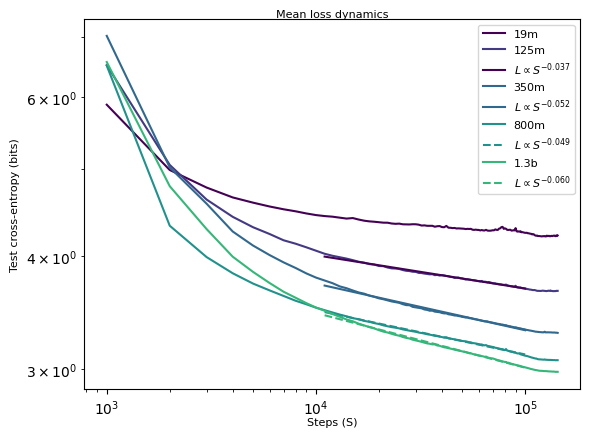

In [127]:
ax = plt.subplot(1, 1, 1)
steps = list(range(1000, 144000, 1000))
colors = plt.cm.viridis(np.linspace(0, 1, len(model_names[:-1])))
plt.plot(steps, timeseries19m_mean, label="19m", color=colors[0])
# X = np.log(steps[10:100]).reshape(-1, 1)
# y = np.log(timeseries1_3b_mean[10:100])
# reg = LinearRegression().fit(X, y)
# ys = np.exp(reg.predict(X))
# plt.plot(steps[10:100], ys, label=r"$L \propto S^{" +  f"{reg.coef_[0]:.3f}" + r"}$", color=colors[0])
plt.plot(steps, timeseries125m_mean, label="125m", color=colors[1])
X = np.log(steps[10:100]).reshape(-1, 1)
y = np.log(timeseries125m_mean[10:100])
reg = LinearRegression().fit(X, y)
ys = np.exp(reg.predict(X))
plt.plot(steps[10:100], ys, label=r"$L \propto S^{" +  f"{reg.coef_[0]:.3f}" + r"}$", color=colors[0])
plt.plot(steps, timeseries350m_mean, label="350m", color=colors[2])
X = np.log(steps[10:100]).reshape(-1, 1)
y = np.log(timeseries350m_mean[10:100])
reg = LinearRegression().fit(X, y)
ys = np.exp(reg.predict(X))
plt.plot(steps[10:100], ys, label=r"$L \propto S^{" +  f"{reg.coef_[0]:.3f}" + r"}$", color=colors[2])
plt.plot(steps, timeseries800m_mean, label="800m", color=colors[3])
X = np.log(steps[10:100]).reshape(-1, 1)
y = np.log(timeseries800m_mean[10:100])
reg = LinearRegression().fit(X, y)
ys = np.exp(reg.predict(X))
plt.plot(steps[10:100], ys, label=r"$L \propto S^{" +  f"{reg.coef_[0]:.3f}" + r"}$", color=colors[3], linestyle='dashed')
plt.plot(steps, timeseries1_3b_mean, label="1.3b", color=colors[4])
X = np.log(steps[10:100]).reshape(-1, 1)
y = np.log(timeseries1_3b_mean[10:100])
reg = LinearRegression().fit(X, y)
ys = np.exp(reg.predict(X))
plt.plot(steps[10:100], ys, label=r"$L \propto S^{" +  f"{reg.coef_[0]:.3f}" + r"}$", color=colors[4], linestyle='dashed')
# plt.xlabel("Steps (S)", fontsize=8)
ax.set_xlabel("Steps (S)", fontsize=8, labelpad=0)
plt.ylabel("Test cross-entropy (bits)", fontsize=8)
plt.xscale("log")
plt.yscale("log")
plt.legend(prop={'size': 8}, loc='upper right')
plt.title("Mean loss dynamics", fontsize=8, pad=0)

In [19]:
parameter_scaling_sacred_ids[alphas[0]]

(13,
 14,
 16,
 18,
 22,
 27,
 48,
 49,
 51,
 86,
 87,
 89,
 188,
 202,
 204,
 205,
 226,
 227,
 99,
 136,
 137)

## Study data scaling

In [13]:
alphas = []
for i in tqdm(range(1, 400)):
    try:
        with open(f"/om/user/ericjm/results/the-everything-machine/D-scaling-9/{i}/config.json", 'r') as f:
            config = json.load(f)
            alphas.append(config['alpha'])
    except:
        pass
alphas = sorted(list(set(alphas)))

  0%|          | 0/399 [00:00<?, ?it/s]

In [14]:
alphas

[1.1,
 1.15,
 1.2,
 1.25,
 1.3,
 1.35,
 1.4,
 1.45,
 1.5,
 1.55,
 1.6,
 1.65,
 1.7,
 1.75,
 1.8]

In [56]:
data_scaling_losses = defaultdict(list)
data_scaling_Ds = defaultdict(list)

for i in tqdm(range(1, 400)):
    try:
        with open(f"/om/user/ericjm/results/the-everything-machine/D-scaling-9/{i}/config.json", 'r') as f:
            config = json.load(f)
        with open(f"/om/user/ericjm/results/the-everything-machine/D-scaling-9/{i}/info.json", 'r') as f:
            info = json.load(f)
        # print(len(info['losses']))
        # break
        if len(info['losses']) != 200:
            raise Exception("Missing timesteps")
        alpha = config['alpha']
        data_scaling_losses[alpha].append(min(info['losses'])*c)
        data_scaling_Ds[alpha].append(info['D'])
    except Exception as e:
        print(e)

  0%|          | 0/399 [00:00<?, ?it/s]

Missing timesteps
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Missing timesteps
Missing timesteps
Missing timesteps
Missing timesteps
Missing timesteps
Missing timesteps
Missing timesteps
Missing timesteps
Missing timesteps
Missing timesteps
Missing timesteps
Missing timesteps
Missing timesteps
Missing timesteps
Missing timesteps
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Missing timesteps
Missing timesteps
Missing timesteps
Missing timesteps
Missing timesteps
Missing timesteps
Missing timesteps
Missing timesteps
Missing timesteps
Missing timesteps
Missing timesteps
[Errno 2] No such file or directory: '/om/user/ericjm/results/the-everything-machine/D-scaling-9/393/config.json'
[Errno 2] No such file or directory: '/om/user/ericjm/results/the-everything-machine/D-scaling-9/394/config.json'
[Errno 2] No such file or director

In [57]:
for alpha in alphas:
    data_scaling_Ds[alpha], data_scaling_losses[alpha] = zip(*sorted(list(zip(data_scaling_Ds[alpha], data_scaling_losses[alpha])), key=lambda x: x[0]))


In [15]:
alphas

[1.1,
 1.15,
 1.2,
 1.25,
 1.3,
 1.35,
 1.4,
 1.45,
 1.5,
 1.55,
 1.6,
 1.65,
 1.7,
 1.75,
 1.8]

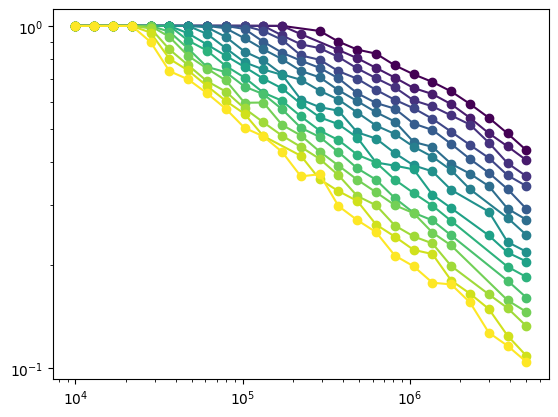

In [59]:
colors = plt.cm.viridis(np.linspace(0, 1, len(alphas)))
for alpha in alphas:
    plt.plot(data_scaling_Ds[alpha], data_scaling_losses[alpha], 'o-', label=alpha, color=colors[alphas.index(alpha)])
plt.xscale('log')
plt.yscale('log')

In [60]:
iis = {alpha: ((np.array(data_scaling_losses[alpha]) < 0.95).nonzero()[0].min(), 25) for alpha in alphas}

/tmp/ipykernel_209507/2614017608.py:20: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label="Task Zipf exponent: $\\alpha+1$", ticks=alphas)


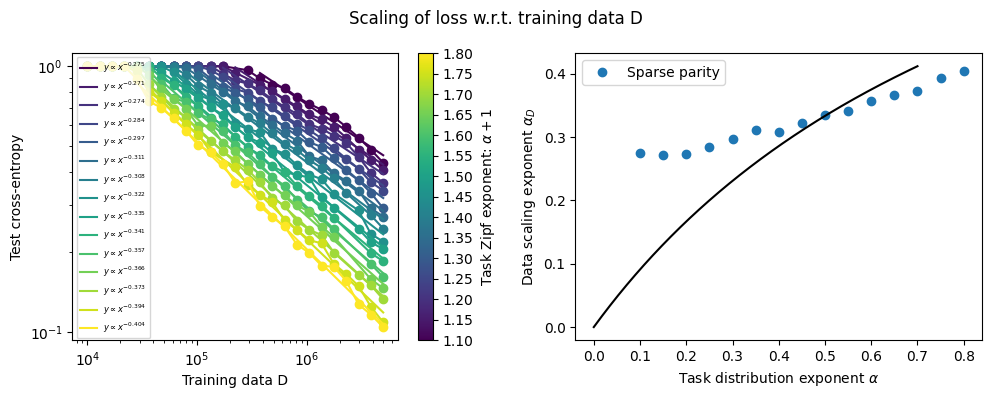

In [61]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
colors = plt.cm.viridis(np.linspace(0, 1, len(alphas)))

slopes = {}
for alpha in alphas:
    plt.plot(data_scaling_Ds[alpha], data_scaling_losses[alpha], 'o-', color=colors[alphas.index(alpha)])

    xs = data_scaling_Ds[alpha]
    ys = data_scaling_losses[alpha]
    i0, i1 = iis[alpha]
    reg = LinearRegression().fit(np.log(xs[i0:i1]).reshape(-1, 1), np.log(ys[i0:i1]))
    reg_ys = np.exp(reg.intercept_) * np.power(xs, reg.coef_[0])
    plt.plot(xs[i0:i1], reg_ys[i0:i1], color=colors[alphas.index(alpha)], label=f"$y\propto x^{{{reg.coef_[0]:.3f}}}$")
    slopes[alpha] = reg.coef_[0]
# add a colorbar for the alphas
sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=plt.Normalize(vmin=min(alphas), vmax=max(alphas)))
sm._A = []
plt.colorbar(sm, label="Task Zipf exponent: $\\alpha+1$", ticks=alphas)
# set colorbar tick labels to be the alphas - 1
# plt.clim(min(alphas), max(alphas))
plt.xscale('log')
plt.xlabel("Training data D")
plt.yscale('log')
plt.ylabel('Test cross-entropy')
plt.legend(prop={'size': 6})


plt.subplot(1, 2, 2)
alphas_arr = np.array(alphas)
plt.plot(alphas_arr-1, [abs(slopes[alpha]) for alpha in alphas], 'o', label='Sparse parity')
xs_alphas = np.linspace(0, 0.7, 1000)
plt.plot(xs_alphas, xs_alphas / (xs_alphas + 1), color='black')
plt.xlabel(r"Task distribution exponent $\alpha$")
plt.ylabel(r"Data scaling exponent $\alpha_D$")
plt.legend()

plt.suptitle("Scaling of loss w.r.t. training data D")
plt.tight_layout(pad=1.0)
plt.savefig('../figures/sparse-parity-data-scaling-dependence.png', dpi=300)

Is the number of subtasks learned consistent with our threshold-based theory? Look at how the number of subtasks learned varies with D and see whether it has slope 1/(alpha+1) on a log-log plot.

In [10]:
data_scaling_ns = defaultdict(list)
data_scaling_Ds = defaultdict(list)

for i in tqdm(range(1, 500)):
    try:
        with open(f"/om/user/ericjm/results/the-everything-machine/D-scaling-9/{i}/config.json", 'r') as f:
            config = json.load(f)
        with open(f"/om/user/ericjm/results/the-everything-machine/D-scaling-9/{i}/info.json", 'r') as f:
            info = json.load(f)
        # print(len(info['losses']))
        # break
        if len(info['losses']) != 200:
            raise Exception("Missing timesteps")
        alpha = config['alpha']
        learned_subtasks = [s for s in info['losses_subtasks'].keys() if min(info['losses_subtasks'][s]) < 0.1]
        data_scaling_ns[alpha].append(len(learned_subtasks))
        data_scaling_Ds[alpha].append(info['D'])
    except Exception as e:
        print(e)

  0%|          | 0/499 [00:00<?, ?it/s]

Missing timesteps
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Missing timesteps
Missing timesteps
Missing timesteps
Missing timesteps
Missing timesteps
Missing timesteps
Missing timesteps
Missing timesteps
Missing timesteps
Missing timesteps
Missing timesteps
Missing timesteps
Missing timesteps
Missing timesteps
Missing timesteps
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Expecting value: line 1 column 1 (char 0)
Missing timesteps
Missing timesteps
Missing timesteps
Missing timesteps
Missing timesteps
Missing timesteps
Missing timesteps
Missing timesteps
Missing timesteps
Missing timesteps
Missing timesteps
[Errno 2] No such file or directory: '/om/user/ericjm/results/the-everything-machine/D-scaling-9/393/config.json'
[Errno 2] No such file or directory: '/om/user/ericjm/results/the-everything-machine/D-scaling-9/394/config.json'
[Errno 2] No such file or director

In [11]:
for alpha in alphas:
    data_scaling_Ds[alpha], data_scaling_ns[alpha] = zip(*sorted(list(zip(data_scaling_Ds[alpha], data_scaling_ns[alpha])), key=lambda x: x[0]))


In [12]:
iis = {}
for alpha in alphas:
    # first index where data_scaling_ns[alpha] > 0
    i0 = (np.array(data_scaling_ns[alpha]) > 0).nonzero()[0].min()
    iis[alpha] = (i0, len(data_scaling_ns[alpha]))

/tmp/ipykernel_239601/1391647237.py:19: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm, ticks=alphas_D)


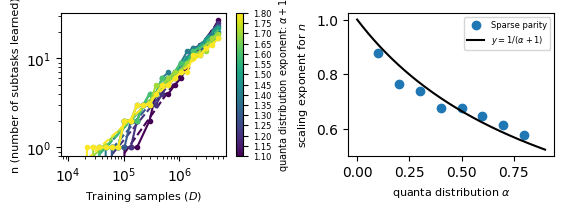

In [19]:
plt.figure(figsize=(5.5, 2))

plt.subplot(1, 2, 1)
slopes = {}
colors = plt.cm.viridis(np.linspace(0, 1, len(alphas)))
for alpha in alphas:
    plt.plot(data_scaling_Ds[alpha], data_scaling_ns[alpha], 'o-', color=colors[alphas.index(alpha)], markersize=3)

    xs = data_scaling_Ds[alpha]
    ys = data_scaling_ns[alpha]
    i0, i1 = iis[alpha]
    reg = LinearRegression().fit(np.log(xs[i0:i1]).reshape(-1, 1), np.log(ys[i0:i1]))
    reg_ys = np.exp(reg.intercept_) * np.power(xs, reg.coef_[0])
    plt.plot(xs[i0:i1], reg_ys[i0:i1], color=colors[alphas.index(alpha)], label=f"$y\propto x^{{{reg.coef_[0]:.3f}}}$", linestyle='--')
    slopes[alpha] = reg.coef_[0]

sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=plt.Normalize(vmin=min(alphas), vmax=max(alphas)))
sm._A = []
cbar = plt.colorbar(sm, ticks=alphas_D)
cbar.ax.set_ylabel(r"quanta distribution exponent: $\alpha + 1$", fontsize=7)
cbar.ax.tick_params(labelsize=6)


plt.xscale('log')
plt.yscale('log')
plt.ylim(0.8, None)
plt.ylabel("n (number of subtasks learned)", fontsize=8)
plt.xlabel("Training samples ($D$)", fontsize=8)
# plt.legend(prop={'size': 6})

plt.subplot(1, 2, 2)
alphas_arr = np.array(alphas)
plt.plot(alphas_arr-1, [abs(slopes[alpha]) for alpha in alphas], 'o', label='Sparse parity')
xs_alphas = np.linspace(0, 0.9, 1000)
plt.plot(xs_alphas, 1 / (xs_alphas + 1), color='black', label=r"$y = 1 / (\alpha + 1)}$")
plt.xlabel(r"quanta distribution $\alpha$", fontsize=8)
plt.ylabel(r"scaling exponent for $n$", fontsize=8)
# plt.plot(alphas_arr, 1 / (alphas_arr), color='black')
plt.legend(prop={'size': 6})

# plt.suptitle("Scaling of number of learned subtasks w.r.t. training data D")
plt.tight_layout(pad=0.2)
# plt.savefig('../figures/sparse-parity-data-scaling-dependence-n.png', dpi=300)

How many subtask 1 datapoints are required to learn it?

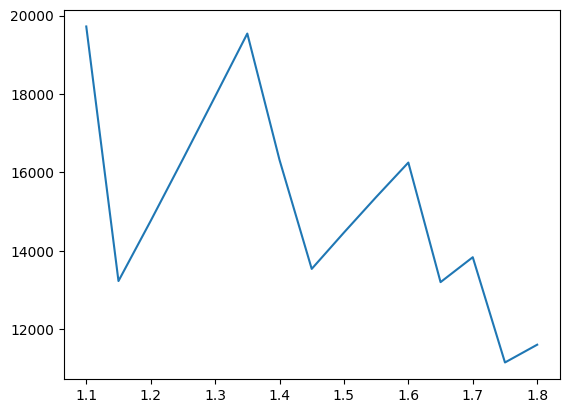

In [27]:
offset = 0
n_tasks = 500
taus = []
for alpha in alphas:
    D = data_scaling_Ds[alpha][iis[alpha][0]]
    probs = np.array([np.power(n, -alpha) for n in range(1+offset, n_tasks+offset+1)])
    probs = probs / np.sum(probs)
    taus.append(D*probs[0])
plt.plot(alphas, taus)


Hmmm this is disappointingly inconsistent. Not sure what to make of the downward trend. Something to do with noise from the other subtasks?

## Can weight decay help?

In [27]:
weight_decays = []
infos = []

for i in tqdm(range(1, 35)):
    try:
        with open(f"/om/user/ericjm/results/the-everything-machine/weight-decay-0/{i}/config.json", 'r') as f:
            config = json.load(f)
        with open(f"/om/user/ericjm/results/the-everything-machine/weight-decay-0/{i}/info.json", 'r') as f:
            info = json.load(f)
        # print(len(info['losses']))
        # break
        if len(info['losses']) != 200:
            raise Exception("Missing timesteps")
        alpha = config['alpha']
        wd = config['weight_decay']
        weight_decays.append(wd)
        infos.append(info)
    except Exception as e:
        print(e)


  0%|          | 0/34 [00:00<?, ?it/s]

Missing timesteps
Missing timesteps
[Errno 2] No such file or directory: '/om/user/ericjm/results/the-everything-machine/weight-decay-0/26/info.json'
[Errno 2] No such file or directory: '/om/user/ericjm/results/the-everything-machine/weight-decay-0/27/config.json'
[Errno 2] No such file or directory: '/om/user/ericjm/results/the-everything-machine/weight-decay-0/28/config.json'
[Errno 2] No such file or directory: '/om/user/ericjm/results/the-everything-machine/weight-decay-0/29/config.json'
[Errno 2] No such file or directory: '/om/user/ericjm/results/the-everything-machine/weight-decay-0/30/config.json'
[Errno 2] No such file or directory: '/om/user/ericjm/results/the-everything-machine/weight-decay-0/31/config.json'
[Errno 2] No such file or directory: '/om/user/ericjm/results/the-everything-machine/weight-decay-0/32/config.json'
[Errno 2] No such file or directory: '/om/user/ericjm/results/the-everything-machine/weight-decay-0/33/config.json'
[Errno 2] No such file or directory: '

In [28]:
weight_decays, infos = zip(*sorted(list(zip(weight_decays, infos)), key=lambda x: x[0]))

In [29]:
weight_decays

(0.001,
 0.0013738237958832629,
 0.0018873918221350972,
 0.004893900918477493,
 0.006723357536499336,
 0.009236708571873862,
 0.01268961003167922,
 0.01743328822199988,
 0.02395026619987485,
 0.03290344562312668,
 0.045203536563602424,
 0.06210169418915615,
 0.08531678524172806,
 0.117210229753348,
 0.1610262027560939,
 0.22122162910704485,
 0.3039195382313197,
 0.41753189365604004,
 0.5736152510448678,
 0.788046281566991,
 1.0826367338740541,
 1.487352107293511,
 2.043359717856941)

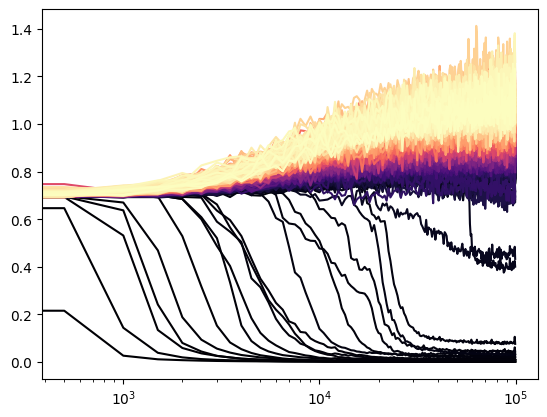

In [40]:
i = -11
colors = plt.cm.magma(np.linspace(0, 1, len(infos[i]['losses_subtasks'])))
for s in range(len(infos[i]['losses_subtasks'])):
    plt.plot(infos[i]['log_steps'], infos[i]['losses_subtasks'][str(s)], color=colors[s])
plt.xscale('log')


In [ ]:
parameter_scaling_alphas = []
parameter_scaling_Ps = []
parameter_scaling_losses = []
parameter_scaling_loss_curves = dict()
parameter_scaling_log_steps = dict()
parameter_scaling_subtask_losses = dict()
for i in tqdm(range(1, 42, 1)):
    try:
        with open(f"/om/user/ericjm/results/the-everything-machine/P-scaling-16/{i}/config.json", 'r') as f:
            config = json.load(f)
            parameter_scaling_alphas.append(config['alpha'])
        with open(f"/om/user/ericjm/results/the-everything-machine/P-scaling-16/{i}/info.json", 'r') as f:
            info = json.load(f)
            if info['P'] in parameter_scaling_Ps:
                continue
            parameter_scaling_losses.append(info['losses'][-1]*c)
            parameter_scaling_loss_curves[info['P']] = np.array(info['losses'])*c
            parameter_scaling_log_steps[info['P']] = info['log_steps']
            parameter_scaling_subtask_losses[info['P']] = [info['losses_subtasks'][str(i)][-1]*c for i in range(500)]
            parameter_scaling_Ps.append(info['P'])
    except Exception as e:
        print(e)

assert all([x == parameter_scaling_alphas[0] for x in parameter_scaling_alphas])
parameter_scaling_alpha = parameter_scaling_alphas[0]

  0%|          | 0/44 [00:00<?, ?it/s]

Expecting ',' delimiter: line 1778962 column 25 (char 33554432)
[Errno 2] No such file or directory: '/om/user/ericjm/results/the-everything-machine/P-scaling-15/14/config.json'
[Errno 2] No such file or directory: '/om/user/ericjm/results/the-everything-machine/P-scaling-15/24/config.json'
[Errno 2] No such file or directory: '/om/user/ericjm/results/the-everything-machine/P-scaling-15/25/config.json'
[Errno 2] No such file or directory: '/om/user/ericjm/results/the-everything-machine/P-scaling-15/26/config.json'
[Errno 2] No such file or directory: '/om/user/ericjm/results/the-everything-machine/P-scaling-15/27/config.json'
[Errno 2] No such file or directory: '/om/user/ericjm/results/the-everything-machine/P-scaling-15/38/config.json'
[Errno 2] No such file or directory: '/om/user/ericjm/results/the-everything-machine/P-scaling-15/39/config.json'
[Errno 2] No such file or directory: '/om/user/ericjm/results/the-everything-machine/P-scaling-15/40/config.json'
[Errno 2] No such file o

In [ ]:
parameter_scaling_Ps, parameter_scaling_losses = zip(*sorted(list(zip(parameter_scaling_Ps, parameter_scaling_losses)), key=lambda x: x[0]))


In [ ]:
len_Ps = len(parameter_scaling_Ps)
n_tasks = len(parameter_scaling_subtask_losses[parameter_scaling_Ps[0]])

parameter_grid = np.zeros((len_Ps, n_tasks))
for i, P in enumerate(parameter_scaling_Ps):
    parameter_grid[i, :] = np.array(parameter_scaling_subtask_losses[P])

In [ ]:
data_scaling_alphas = []
data_scaling_Ds = []
data_scaling_losses = []
data_scaling_subtask_losses = dict()
min_idxs = []
for i in tqdm(range(1, 31, 1)):
    try:
        with open(f"/om/user/ericjm/results/the-everything-machine/D-scaling-6/{i}/config.json", 'r') as f:
            config = json.load(f)
            data_scaling_alphas.append(config['alpha'])
        with open(f"/om/user/ericjm/results/the-everything-machine/D-scaling-6/{i}/info.json", 'r') as f:
            info = json.load(f)
            min_idx = min(list(range(len(info['losses']))), key=lambda i: info['losses'][i])
            min_idxs.append(min_idx)
            data_scaling_losses.append(info['losses'][min_idx]*c)
            data_scaling_subtask_losses[info['D']] = [info['losses_subtasks'][str(i)][min_idx]*c for i in range(200)]
            data_scaling_Ds.append(info['D'])
    except Exception as e:
        print(e)

  0%|          | 0/30 [00:00<?, ?it/s]

In [ ]:
assert all([x == data_scaling_alphas[0] for x in data_scaling_alphas])
data_scaling_alpha = data_scaling_alphas[0]

In [ ]:
data_scaling_Ds, data_scaling_losses = zip(*sorted(list(zip(data_scaling_Ds, data_scaling_losses)), key=lambda x: x[0]))

In [ ]:
len_Ds = len(data_scaling_Ds)
n_tasks = len(data_scaling_subtask_losses[data_scaling_Ds[0]])

data_grid = np.zeros((len_Ds, n_tasks))
for i, P in enumerate(data_scaling_Ds):
    data_grid[i, :] = np.array(data_scaling_subtask_losses[P])

In [ ]:
len_Ps = len(parameter_scaling_Ps)
n_tasks = len(parameter_scaling_subtask_losses[parameter_scaling_Ps[0]])

parameter_grid = np.zeros((len_Ps, n_tasks))
for i, P in enumerate(parameter_scaling_Ps):
    parameter_grid[i, :] = np.array(parameter_scaling_subtask_losses[P])

### Are small models trained to convergence?

In [81]:
alphas = []
for i in tqdm(range(1, 50)):
    try:
        with open(f"/om/user/ericjm/results/the-everything-machine/P-scaling-16/{i}/config.json", 'r') as f:
            config = json.load(f)
            alphas.append(config['alpha'])
    except:
        pass
alphas = sorted(list(set(alphas)))

  0%|          | 0/49 [00:00<?, ?it/s]

In [82]:
alphas

[1.2, 1.3, 1.4, 1.5]

In [83]:
for i in tqdm(range(1, 50)):
    try:
        with open(f"/om/user/ericjm/results/the-everything-machine/P-scaling-16/{i}/config.json", 'r') as f:
            config = json.load(f)
            print(i, config['width'], config['alpha'])
    #     with open(f"/om/user/ericjm/results/the-everything-machine/P-scaling-16/{i}/info.json", 'r') as f:
    #         info = json.load(f)
    #     if len(info['losses']) != 200:
    #         raise Exception("Missing timesteps")
    #     alpha = config['alpha']
    #     parameter_scaling_losses[alpha].append(info['losses'][-1])
    #     parameter_scaling_Ps[alpha].append(info['P'])
    except Exception as e:
        print(e)

  0%|          | 0/49 [00:00<?, ?it/s]

1 21 1.5
2 9 1.4
3 45 1.2
4 45 1.4
5 45 1.5
6 45 1.3
7 31 1.5
8 31 1.3
9 31 1.4
10 66 1.2
11 66 1.4
12 31 1.2
13 66 1.3
14 9 1.3
15 96 1.4
16 96 1.2
17 96 1.3
18 66 1.5
19 21 1.2
20 21 1.3
21 14 1.5
22 21 1.4
23 9 1.5
24 14 1.4
25 14 1.3
26 14 1.2
27 9 1.2
[Errno 2] No such file or directory: '/om/user/ericjm/results/the-everything-machine/P-scaling-16/28/config.json'
[Errno 2] No such file or directory: '/om/user/ericjm/results/the-everything-machine/P-scaling-16/29/config.json'
[Errno 2] No such file or directory: '/om/user/ericjm/results/the-everything-machine/P-scaling-16/30/config.json'
[Errno 2] No such file or directory: '/om/user/ericjm/results/the-everything-machine/P-scaling-16/31/config.json'
[Errno 2] No such file or directory: '/om/user/ericjm/results/the-everything-machine/P-scaling-16/32/config.json'
[Errno 2] No such file or directory: '/om/user/ericjm/results/the-everything-machine/P-scaling-16/33/config.json'
[Errno 2] No such file or directory: '/om/user/ericjm/resul

In [88]:
with open(f"/om/user/ericjm/results/the-everything-machine/P-scaling-16/3/config.json", 'r') as f:
    config = json.load(f)
with open(f"/om/user/ericjm/results/the-everything-machine/P-scaling-16/3/info.json", 'r') as f:
    info = json.load(f)

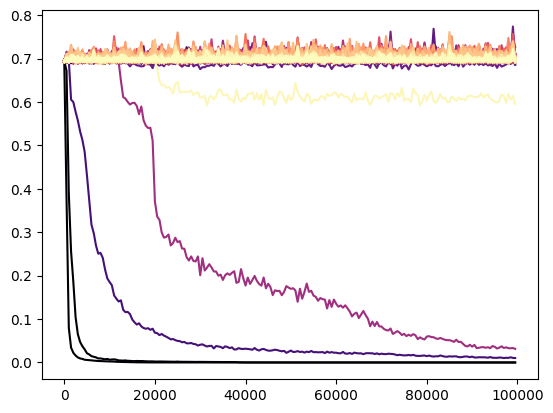

In [89]:
colors = plt.cm.magma(np.linspace(0, 1, len(info['losses_subtasks'])))
for i, s in enumerate(info['losses_subtasks']):
    plt.plot(info['log_steps'], info['losses_subtasks'][s], color=colors[i])
# plt.plot(info['log_steps'], info['losses'])